In [27]:
import gmaps
import numpy as np
import gmaps.datasets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
import influxdb
import requests
import impyute
from datetime import datetime as dt
import datetime
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import pykalman as pk
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA
from numpy import ma
import itertools
import warnings
import copy

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

In [28]:
auth = pd.read_json('../auth.json',typ='series')
client = influxdb.DataFrameClient(auth.influxdb['hostname'], 8086, ssl=True, username=auth.influxdb['username'], password=auth.influxdb['password'])

# PM data
## Data cleaning

In [29]:
coords = client.query("select * from coords", database="sensenet_coords")
userData = coords['coords']
userData = userData.reset_index(drop=True)
userData=userData.rename(columns={"box":"dev_id"})
userData.dev_id=[(int)(x.split('x')[-1]) for x in userData.dev_id]
userData

dev_id   latitude  longitude     type         uid
0      11  38.029883 -78.484047  outdoor          LF
1      10  38.030613 -78.479057  outdoor         CCI
2       9  38.025759 -78.469295  outdoor      Jon K.
3       8  38.047450 -78.483030  outdoor   Angela O.
4       7  38.025570 -78.516610  outdoor     Lane R.
5       6  38.025092 -78.503586  outdoor    Jimmy H.
6       5  38.045801 -78.503947  outdoor  Francis R.
7       4  38.027580 -78.515191  outdoor     Alex N.
8       3  38.024780 -78.484580  outdoor    Lucas A.
9       2  38.065460 -78.495820  outdoor    Zihao Z.

In [30]:
complete_df = client.query("select * from \"sensenet-test\"", database="sensornet_db")
pmData = complete_df['sensenet-test']
pmData[['dev_id','pm25', 'pm10', 'co2', 'temp', 'humidity', 'gtw_id', 'rssi', 'snr']].head()
#sbox2 has basically no data
boxes = ['sbox'+str(i) for i in range(2,12)]
pmData = pmData[pmData.dev_id.isin(boxes)]
pmData.dev_id=[(int)(x.split('x')[-1]) for x in pmData.dev_id]
pmData=pmData.join(userData,on='dev_id',rsuffix='_user',how="outer")
pmData=pmData.reset_index()
pmData=pmData.rename(columns={"index":"time"})
pmData.head()

/Users/benschenck/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


time     airtime  channel    co2 data_rate  \
0 2020-02-03 00:36:03.779007152+00:00  61696000.0      3.0  144.0  SF7BW125   
1 2020-02-03 00:51:03.804609070+00:00  61696000.0      7.0  140.0  SF7BW125   
2 2020-02-03 01:06:04.829307469+00:00  61696000.0      5.0  149.0  SF7BW125   
3 2020-02-03 01:21:03.771676500+00:00  61696000.0      4.0  144.0  SF7BW125   
4 2020-02-03 01:36:03.768423914+00:00  61696000.0      5.0  132.0  SF7BW125   

   dev_id  frequency         gtw_id  humidity   latitude  ...  pm25  rssi  \
0       6      904.5  sds-gateway-3     62.89  38.026337  ...   0.0 -14.0   
1       6      905.3  sds-gateway-3     62.82  38.026337  ...   0.0 -15.0   
2       6      904.9  sds-gateway-3     62.14  38.026337  ...   0.0 -15.0   
3       6      904.7  sds-gateway-3     61.29  38.026337  ...   0.0 -16.0   
4       6      904.9  sds-gateway-3     60.77  38.026337  ...   0.0 -13.0   

     snr   temp     timestamp  dev_id_user  latitude_user  longitude_user  \
0   9.00  12.52  4.366491e+08          5.0      38.045801      -78.503947   
1   9.00  12.82  1.336640e+09          5.0      38.045801      -78.503947   
2  10.75  13.17  2.237630e+09          5.0      38.045801      -78.503947   
3  10.00  13.51  3.136621e+09          5.0      38.045801      -78.503947   
4  10.50  13.63  4.036612e+09          5.0      38.045801      -78.503947   

      type         uid  
0  outdoor  Francis R.  
1  outdoor  Francis R.  
2  outdoor  Francis R.  
3  outdoor  Francis R.  
4  outdoor  Francis R.  

[5 rows x 22 columns]

In [31]:
pmData['strTime'] = pmData['time']

In [32]:
for i in range(len(pmData["time"])):
    pmData['strTime'][i] = str(pmData['time'][i])

/Users/benschenck/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
pmData['fdt'] = pmData['time']

In [34]:
for i in range(len(pmData["strTime"])):
    try:
        pmData['fdt'][i] = dt.strptime(pmData['strTime'][i][0:19], '%Y-%m-%d %H:%M:%S')
    except:
        pmData['fdt'][i] = pd.NaT

/Users/benschenck/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
pm = pmData[['co2','pm25','pm10','temp','humidity','latitude','longitude','dev_id','fdt']]

Below are 4 functions for:

1. rmRepeatedConsts: removing repeated constant values

2. rmRepeatedZeros: removing repeated zeros (probably handled by first function but wanted to be safe)

3. rmOutsideRanges: removing values outside of a defined range for each features

4. rmOutliers: running all three of the previous functions together

In [36]:
# https://www.geeksforgeeks.org/insert-row-at-given-position-in-pandas-dataframe/
def Insert_row_(row_number, df, row_value): 
    # Slice the upper half of the dataframe 
    df1 = df[0:row_number] 
   
    # Store the result of lower half of the dataframe 
    df2 = df[row_number:] 
   
    # Inser the row in the upper half dataframe 
    df1.loc[row_number]=row_value 
   
    # Concat the two dataframes 
    df_result = pd.concat([df1, df2]) 
   
    # Reassign the index labels 
    df_result.index = [*range(df_result.shape[0])] 
   
    # Return the updated dataframe 
    return df_result 

In [37]:
#clean up by making rmOutliers loop over the rows and keys instead of looping over them in each function

def rmRepeatedConsts(frame,cols,sensitivity):
    prev_cts = {x:0 for x in cols}
    prev = {x:0 for x in cols}
    for i, row in frame.iterrows():
        for key in prev.keys():
            if prev_cts[key]>=sensitivity and row[key]==prev[key]:
                frame.at[i,key] = np.NaN
            elif row[key]==prev[key]:
                prev_cts[key]+=1
            else:
                prev_cts[key]=0
            prev[key]=row[key]
    return frame

def rmRepeatedZeros(frame,cols,sensitivity):
    prev_cts = {x:0 for x in cols}
    for i, row in frame.iterrows():
        for key in prev_cts.keys():
            if prev_cts[key]>=sensitivity and row[key]==0:
                frame.at[i,key] = np.NaN
            elif row[key]==0:
                prev_cts[key]+=1
            else:
                prev_cts[key]=0
    return frame

def rmOutsideRanges(frame,cols,ranges):
    for i, row in frame.iterrows():
        for feature in cols:
            if (row[feature]<ranges[feature][0]) or (row[feature]>ranges[feature][1]):
                frame.at[i,feature] = np.NaN
    return frame

def rmLinear(frame,cols,sensitivity):
    prev_cts = {x:0 for x in cols} # times the diff bt row and lastrow has been the same
    prev = {x:0 for x in cols} # distance between row and lastrow
    lastrow = {x:0 for x in cols}
    row_unmodified = {x:0 for x in cols}
    for i, row in frame.iterrows():
        row_unmodified = copy.deepcopy(row)
        for key in prev.keys():
            if prev_cts[key]>=sensitivity and (row[key]-lastrow[key])==prev[key]:
                frame.at[i,key] = np.NaN
            elif (row[key]-lastrow[key])==prev[key]:
                prev_cts[key]+=1
            else:
                prev[key]=(row[key]-lastrow[key])
                prev_cts[key]=0
        lastrow = row_unmodified
    return frame

# def rmTimeSeparation(frame,cols,sensitivity):
#     prev = {x:0 for x in cols} # distance between row and lastrow
#     for i, row in frame.iterrows():
#         for key in prev.keys():
#             try:
#                 if (row[key]-prev[key]).seconds/60 > sensitivity :
#                     frame.at[i,key] = np.NaN
#                 prev[key] = row[key]
#             except:
#                 prev[key] = row[key]
#     return frame

def addTimeSteps(frame,cols,time_col,sensitivity):
    prev = {time_col:0} # distance between row and lastrow
    for i, row in frame.iterrows():
        try:
            while (row[time_col]-prev[time_col]).seconds/60 > sensitivity :
                new_row = {x:0 for x in cols}
                new_row[time_col] = prev[time_col]+datetime.timedelta(minutes=sensitivity)
                Insert_row_(i, df, new_row)
                prev[time_col] = row[time_col]
        except:
            prev[time_col] = row[time_col]
    return frame

def rmOutliers(frame,sensitivity,time_sensitivity,reading_time):
    boxes=[3,4,5,6,7,8,9,10,11]
    features = ["co2","pm25","pm10","temp","humidity"]
    acceptable_ranges={"co2":[0,2000],"pm25":[0,40],"pm10":[0,40],"temp":[0,41],"humidity":[0,100]}
    box_frames=[]
    for box in boxes:
        box_frame = frame[frame.dev_id == box]
        box_frame = rmRepeatedConsts(box_frame,features,sensitivity)
        box_frame = rmRepeatedZeros(box_frame,features,sensitivity)
        box_frame = rmOutsideRanges(box_frame,features,acceptable_ranges)
        box_frame = rmLinear(box_frame,features,sensitivity)
        #box_frame = rmTimeSeparation(box_frame,['fdt'],time_sensitivity)
        box_frame = addTimeSteps(box_frame,features,'fdt',reading_time)
        box_frames.append(box_frame)
    return pd.concat(box_frames, ignore_index=True)

In [38]:
pm_na = rmOutliers(pm,1,60,15)

In [16]:
pm_na.fdt[0]+datetime.timedelta(minutes=15)

datetime.datetime(2020, 2, 3, 0, 55, 39)

In [39]:
pm_na.head()

co2  pm25  pm10   temp  humidity   latitude  longitude  dev_id  \
0  1247.0   0.0   0.0  19.29     37.97  38.030388    -78.484       3   
1  1131.0   NaN   NaN  19.33     38.34  38.030388    -78.484       3   
2  1131.0   NaN   NaN  20.40     37.63  38.030388    -78.484       3   
3   786.0  23.0  23.0  22.84     35.00  38.030388    -78.484       3   
4   785.0  30.0  33.0  22.94     35.39  38.030388    -78.484       3   

                   fdt  
0  2020-02-03 00:40:39  
1  2020-02-03 00:55:39  
2  2020-02-03 01:10:39  
3  2020-02-03 01:37:25  
4  2020-02-03 01:52:25

In [76]:
#could use this to linearly interpolate for the ARIMA method that Jon mentioned
pm_na.interpolate().head()

co2       pm25       pm10   temp  humidity   latitude  longitude  \
0  1247.0   0.000000   0.000000  19.29     37.97  38.030388    -78.484   
1  1131.0   7.666667   7.666667  19.33     38.34  38.030388    -78.484   
2  1131.0  15.333333  15.333333  20.40     37.63  38.030388    -78.484   
3   786.0  23.000000  23.000000  22.84     35.00  38.030388    -78.484   
4   785.0  30.000000  33.000000  22.94     35.39  38.030388    -78.484   

   dev_id                  fdt  
0       3  2020-02-03 00:40:39  
1       3  2020-02-03 00:55:39  
2       3  2020-02-03 01:10:39  
3       3  2020-02-03 01:37:25  
4       3  2020-02-03 01:52:25

In [40]:
pm_na.sort_values("dev_id")

co2  pm25  pm10   temp  humidity   latitude  longitude  dev_id  \
0      1247.0   0.0   0.0  19.29     37.97  38.030388  -78.48400       3   
1516    429.0   1.0   1.0   2.06     47.34  38.020855  -78.47398       3   
1515    421.0   NaN   NaN   1.98     47.10  38.020855  -78.47398       3   
1514    420.0   0.0   0.0   2.13     46.82  38.020855  -78.47398       3   
1513    419.0   4.0   6.0   2.33     46.60  38.020855  -78.47398       3   
1512    427.0   3.0   3.0   2.53     46.54  38.020855  -78.47398       3   
1511    423.0   2.0   2.0   2.74     46.58  38.020855  -78.47398       3   
1510    430.0   3.0   3.0   2.84     46.40  38.020855  -78.47398       3   
1509    420.0   NaN   NaN   2.97     46.34  38.020855  -78.47398       3   
1508    427.0   NaN   NaN   3.11     46.31  38.020855  -78.47398       3   
1507    419.0   0.0   0.0   3.22     46.19  38.020855  -78.47398       3   
1506    421.0   3.0   3.0   3.29     46.06  38.020855  -78.47398       3   
1505    427.0   NaN   NaN   3.32     46.03  38.020855  -78.47398       3   
1504    421.0   NaN   NaN   3.43     45.92  38.020855  -78.47398       3   
1503    427.0   NaN   NaN   3.52     45.75  38.020855  -78.47398       3   
1502    424.0   NaN   NaN   3.70     45.73  38.020855  -78.47398       3   
1501    426.0   NaN   NaN   3.84     45.38  38.020855  -78.47398       3   
1500    437.0   NaN   NaN   3.98     45.28  38.020855  -78.47398       3   
1486    437.0   1.0   1.0   5.38     43.17  38.020855  -78.47398       3   
1487    424.0   0.0   0.0   5.32     43.37  38.020855  -78.47398       3   
1488    428.0   NaN   NaN   5.21     43.44  38.020855  -78.47398       3   
1489    423.0   NaN   NaN   5.05     43.28  38.020855  -78.47398       3   
1490    431.0   NaN   NaN   4.90     43.25  38.020855  -78.47398       3   
1491    432.0   NaN   NaN   4.87     43.56  38.020855  -78.47398       3   
1517    421.0   0.0   0.0   2.09     47.30  38.020855  -78.47398       3   
1492    428.0   NaN   NaN   4.79     43.62  38.020855  -78.47398       3   
1494    422.0   NaN   NaN   4.57     43.65  38.020855  -78.47398       3   
1495    422.0   1.0   1.0   4.48     43.81  38.020855  -78.47398       3   
1496    425.0   1.0   1.0   4.36     44.11  38.020855  -78.47398       3   
1497    431.0   0.0   0.0   4.23     44.50  38.020855  -78.47398       3   
...       ...   ...   ...    ...       ...        ...        ...     ...   
14967   435.0   3.0   3.0  19.07     46.78  38.030388  -78.48400      11   
14969   432.0  17.0  17.0  19.10     46.80  38.030388  -78.48400      11   
14970   432.0   7.0  22.0  19.14     46.82  38.030388  -78.48400      11   
14971   438.0   7.0   7.0  19.08     46.85  38.030388  -78.48400      11   
14972   454.0   4.0   4.0  19.17     46.87  38.030388  -78.48400      11   
14973   471.0   7.0   7.0  19.28     46.85  38.030388  -78.48400      11   
14974   486.0  12.0  12.0  19.34     46.78  38.030388  -78.48400      11   
14975   510.0  11.0  16.0  19.34     46.80  38.030388  -78.48400      11   
14968   435.0   6.0   6.0  19.08     46.78  38.030388  -78.48400      11   
14938   411.0   1.0   1.0  18.87     46.59  38.030388  -78.48400      11   
14958   413.0   3.0   5.0  17.97     47.05  38.030388  -78.48400      11   
14956   411.0   2.0   6.0  17.94     47.42  38.030388  -78.48400      11   
14940   416.0   NaN   NaN  17.99     45.99  38.030388  -78.48400      11   
14941   408.0   NaN   NaN  18.04     46.83  38.030388  -78.48400      11   
14942   414.0   NaN   NaN  18.81     46.22  38.030388  -78.48400      11   
14943   406.0   NaN   NaN  19.08     46.03  38.030388  -78.48400      11   
14944   406.0   NaN   NaN  17.34     46.17  38.030388  -78.48400      11   
14945   412.0   NaN   NaN  18.19     46.91  38.030388  -78.48400      11   
14946   407.0   NaN   NaN  18.23     47.07  38.030388  -78.48400      11   
14957   420.0   2.0   5.0  17.91     47.08  38.030388  -78.48400      11   
14947   414.0   2.0   2.0  18.38     46.40  38.030388  -78

In [42]:
pm_na.groupby('dev_id').agg('mean')

co2      pm25      pm10       temp   humidity   latitude  \
dev_id                                                                    
3       431.254675  1.707865  1.920507  10.486396  52.067765  38.022141   
4       465.803270  1.800000  2.115207  12.483725  58.932836  38.027560   
5       496.498385  3.800915  4.303371   9.965023  52.364441  38.035467   
6       225.677387  1.611111  1.950673  11.202418  62.222006  38.026337   
7       543.795502  1.977870  2.580524   8.721360  50.625917  38.027724   
8       575.115702  2.125756  2.398693  19.945471  43.960337  38.030388   
9       316.401837  2.442308  2.583113  10.566606  55.134692  38.030388   
10      477.587446  2.935176  3.286492  15.609981  44.690363  38.030686   
11      494.818579  1.951181  2.142101  19.739281  40.258389  38.030388   

        longitude  
dev_id             
3      -78.474799  
4      -78.515207  
5      -78.492034  
6      -78.504610  
7      -78.513574  
8      -78.483981  
9      -78.484000  
10     -78.479201  
11     -78.483984

## Data imputation
### Mean

Now that NaN values have been added for missing points, fill in these NaNs using a chosen method. First we try just using the mean.

In [77]:
# start_date = min(pm_na.fdt)
# end_date = max(pm_na.fdt)

TypeError: '<' not supported between instances of 'float' and 'datetime.datetime'

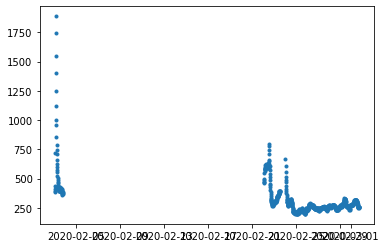

In [103]:
plt.plot(pm_na[pm_na.dev_id==9]['fdt'],pm_na[pm_na.dev_id==9]['co2'],'.')

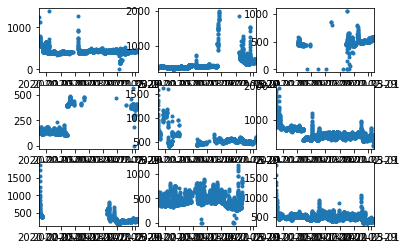

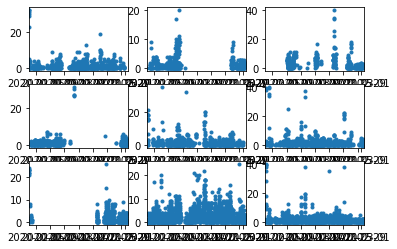

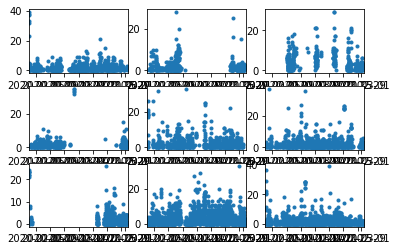

In [104]:
#co2 plots after making missing values into NaNs for boxes 3:11
#using df.interpolate() to fill NAs with linearly-interpolated values
plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(pm_na[pm_na.dev_id==i+3]['fdt'],pm_na[pm_na.dev_id==i+3]['co2'],'.')
    plt.xlim(start_date,end_date)
    plt.axis(option=False)
plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(pm_na[pm_na.dev_id==i+3]['fdt'],pm_na[pm_na.dev_id==i+3]['pm25'],'.')
    plt.xlim(start_date,end_date)
    plt.axis(option=False)
plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(pm_na[pm_na.dev_id==i+3]['fdt'],pm_na[pm_na.dev_id==i+3]['pm10'],'.')
    plt.xlim(start_date,end_date)
    plt.axis(option=False)

In [68]:
def findConsecutives(inds):
    consecutives = []
    start=inds[0]
    lastval=inds[0]
    for i in range(1,len(inds)):
        if (inds[i]!=lastval+1) or (i==len(inds)-1):
            consecutives.append((start,inds[i-1]))
            start=inds[i]
        lastval=inds[i]
    return consecutives

### ARIMA

In [103]:
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
#PDQ grid-search
# Define the p, d and q parameters to take any value between 0 and 2
d = range(0, 3)
p = range(4,5)
q = range(4,7)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    try:
        mod = ARIMA(series,order=param)

        results = mod.fit()

        print('ARIMA{}x - AIC:{}'.format(param, results.aic))
    except:
        continue

C:\Users\Jime\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Jime\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


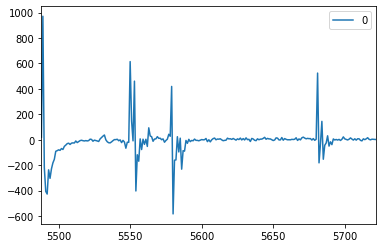

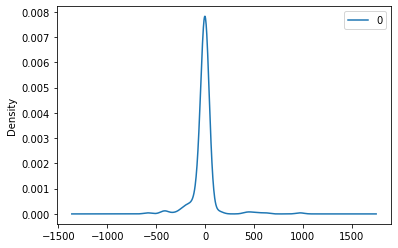

In [68]:
#https://stackoverflow.com/questions/14016247/find-integer-index-of-rows-with-nan-in-pandas-dataframe

# fit model
model = ARIMA(series[0:ind_sets[0][0]], order=(4,2,4))
model_fit = model.fit(disp=0)
#print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
#print(residuals.describe())

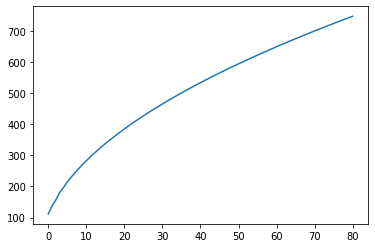

In [70]:
new_points = model_fit.forecast(ind_sets[0][1]-ind_sets[0][0])
plt.plot(new_points[1])

the areas with no values are usually split up and we don't want to predict values that already exist, so I made a function to get the beginning and ending indices of these NA areas

In [105]:
#attempt at replacing missing values with arima prediction (doesn't work so great)
plt.figure()
plt.plot(pm_na[pm_na.dev_id==7]['co2'])
series = pm_na[pm_na.dev_id==7]['co2']
plt.figure()
plt.plot(series)
replacement_sets=[]
for set in ind_sets:
    replacements=model_fit.predict(start=set[0],end=set[1])
    replacement_sets.append(replacements)
    for i in range(set[0],set[1]):
        j = i + series.index[0]
        series[j]=replacements[j]+series[set[0]-1]
plt.figure()
for set in replacement_sets:
    plt.plot(set)
plt.figure()
plt.plot(series)

KeyError: 5723

### Kalman Smoothing

https://pykalman.github.io/#pykalman.KalmanFilter.em

seems to just shrink the y axis

the difference between linear interpolation and kalman smoothing is unnoticeable, am I parameterizing this incorrectly?

running this in R gave the same results: basically just linear interpolation.

does this method not work for large swathes of missing data? It seems to work really well in general from what I've read

In [21]:
series = pm_na[pm_na.dev_id==7]['co2']
inds = pm_na[pm_na.dev_id==7]['co2'].isnull()
inds = [1 if x else 0 for x in inds]
series_masked = ma.array(list(series),mask=inds)

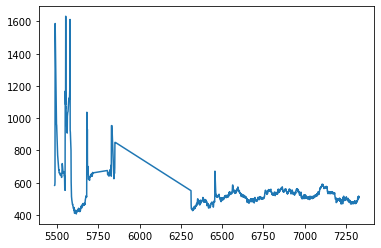

In [22]:
plt.plot(pm_na[pm_na.dev_id==7]['co2'].interpolate())

In [23]:
kf = pk.KalmanFilter(initial_state_mean=100, n_dim_obs=1)
kfem = kf.em(series_masked,n_iter=5)
series_smoothed = kfem.smooth(series_masked)

Generating values from the distribution found from kf.em gives realistic, albeit including negative, values

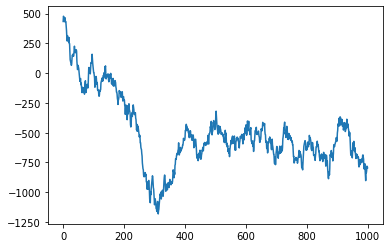

In [24]:
plt.plot(kfem.sample(1000)[0])

However the resulting predictions for our data become straight lines?

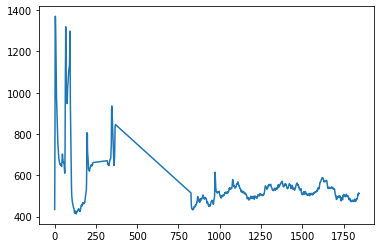

In [25]:
series_smoothed = kfem.smooth(series_masked)
plt.plot(series_smoothed[0])

# Weather data

In [26]:
pwsIDs = [105, 171, 111, 136, 112, 80, 106, 176, 134, 8]

In [27]:
geo = pd.read_csv('../data/geo.csv')

In [28]:
weatherData = pd.read_csv("../data/2020-01-01,2020-02-22.csv")

In [29]:
weatherData=weatherData.join(geo.set_index('pws'),on="pws")

In [30]:
weatherData['DateTime']=[dt.strptime(x,'%Y-%m-%d %I:%M %p') for x in (weatherData.date + " " + weatherData.Time)]

In [31]:
weatherData.head()

Unnamed: 0      Time Temperature Dew Point Humidity Wind    Speed     Gust  \
0           1  12:04 AM      41.5 F    27.5 F     57 %   NE  0.0 mph  0.0 mph   
1           2  12:09 AM      41.5 F    27.5 F     57 %   NE  0.0 mph  0.0 mph   
2           3  12:14 AM      41.4 F    27.6 F     58 %  ESE  0.1 mph  0.2 mph   
3           4  12:19 AM      41.2 F    27.9 F     59 %   SE  0.0 mph  0.2 mph   
4           5  12:24 AM      41.0 F    27.9 F     59 %   SE  0.0 mph  0.0 mph   

   Pressure Precip. Rate.  ...   UV   Solar        date    pws     lat  \
0  29.19 in       0.00 in  ...  0.0  0 w/m²  2020-01-01  171.0  38.046   
1  29.19 in       0.00 in  ...  0.0  0 w/m²  2020-01-01  171.0  38.046   
2  29.19 in       0.00 in  ...  0.0  0 w/m²  2020-01-01  171.0  38.046   
3  29.20 in       0.00 in  ...  0.0  0 w/m²  2020-01-01  171.0  38.046   
4  29.20 in       0.00 in  ...  0.0  0 w/m²  2020-01-01  171.0  38.046   

   lat_dir    long  long_dir elevation            DateTime  
0        N  78.495         E       581 2020-01-01 00:04:00  
1        N  78.495         E       581 2020-01-01 00:09:00  
2        N  78.495         E       581 2020-01-01 00:14:00  
3        N  78.495         E       581 2020-01-01 00:19:00  
4        N  78.495         E       581 2020-01-01 00:24:00  

[5 rows x 21 columns]

# make dataframe for predictions
## for each of PM2.5,PM10,C02 there is a dataframe where each row contains:
- response variable = one of the 10 AQ stations
- features:
    - the other 9 AQ station features and their distances to the response station
    - all 10 weather station features and their distance to the response station
- one record per 5 minutes

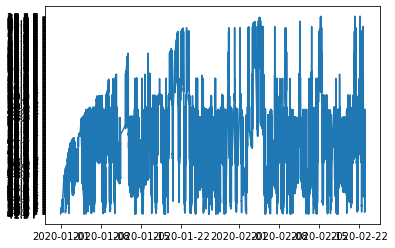

In [34]:
plt.plot(weatherData[weatherData.pws==171.0].DateTime,weatherData[weatherData.pws==171.0].Temperature)

In [35]:
gmaps.configure(api_key=auth.gmaps['api_key']) # Your Google API key

In [36]:
#weather data one reading per 5 mins
#pm data one reading per 15 mins
#must move through time and for each 5 mins get the closest data point for each weather station and each AQ station
#each row has predictors from all stations with one AQ station removed
#thus we have the same # of rows as the weather data because 1 row for each of the 10 stations is combined into 1 row
#all of the AQ data is applied, and then it is multiplied out by 10 for predicting each of the AQ stations

In [37]:
pmData=pmData.sort_values(by=['DateTime'])
weatherData=weatherData.sort_values(by=['DateTime'])

KeyError: 'DateTime'

In [102]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
series = pm_na[pm_na.dev_id==7]['co2'].interpolate()
inds = np.where(pm_na[pm_na.dev_id==7]['co2'].isnull())[0]
ind_sets = findConsecutives(inds)

for param in pdq:
    try:
        mod = ARIMA(series, order=param)
        results = mod.fit()

        print('ARIMA{}x - AIC:{}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 4)x - AIC:19790.53372453084
ARIMA(0, 0, 5)x - AIC:19617.291095794542
ARIMA(0, 0, 6)x - AIC:19448.73435896732
ARIMA(0, 1, 4)x - AIC:18928.197117216343
ARIMA(0, 1, 5)x - AIC:18926.768461170825
ARIMA(0, 1, 6)x - AIC:18927.543174300637
ARIMA(1, 0, 4)x - AIC:18924.960243219713
ARIMA(1, 0, 5)x - AIC:18925.834649129523
ARIMA(1, 0, 6)x - AIC:18927.623193224958
ARIMA(1, 1, 4)x - AIC:18925.54461767945
ARIMA(1, 1, 5)x - AIC:18908.553412222052
ARIMA(1, 1, 6)x - AIC:18921.234703668535
ARIMA(1, 2, 6)x - AIC:18922.327118644436
ARIMA(2, 0, 4)x - AIC:18925.655617959146
ARIMA(2, 0, 5)x - AIC:18922.207766174215
ARIMA(2, 0, 6)x - AIC:18920.18119270142
ARIMA(2, 1, 4)x - AIC:18922.703013753573
ARIMA(2, 1, 5)x - AIC:18909.568177796795
ARIMA(2, 1, 6)x - AIC:18901.68738632803
ARIMA(3, 0, 4)x - AIC:18926.27161361504
ARIMA(3, 0, 5)x - AIC:18923.593506923207
ARIMA(3, 0, 6)x - AIC:18915.59536840057
ARIMA(3, 1, 4)x - AIC:18915.789843884268


ARIMA(0, 0, 4)x - AIC:19790.53372453084
ARIMA(0, 0, 5)x - AIC:19617.291095794542
ARIMA(0, 0, 6)x - AIC:19448.73435896732
ARIMA(0, 1, 4)x - AIC:18928.197117216343
ARIMA(0, 1, 5)x - AIC:18926.768461170825
ARIMA(0, 1, 6)x - AIC:18927.543174300637
ARIMA(1, 0, 4)x - AIC:18924.960243219713
ARIMA(1, 0, 5)x - AIC:18925.834649129523
ARIMA(1, 0, 6)x - AIC:18927.623193224958
ARIMA(1, 1, 4)x - AIC:18925.54461767945
ARIMA(1, 1, 5)x - AIC:18908.553412222052
ARIMA(1, 1, 6)x - AIC:18921.234703668535
ARIMA(1, 2, 6)x - AIC:18922.327118644436
ARIMA(2, 0, 4)x - AIC:18925.655617959146
ARIMA(2, 0, 5)x - AIC:18922.207766174215
ARIMA(2, 0, 6)x - AIC:18920.18119270142
ARIMA(2, 1, 4)x - AIC:18922.703013753573
ARIMA(2, 1, 5)x - AIC:18909.568177796795
ARIMA(2, 1, 6)x - AIC:18901.68738632803
ARIMA(3, 0, 4)x - AIC:18926.27161361504
ARIMA(3, 0, 5)x - AIC:18923.593506923207
ARIMA(3, 0, 6)x - AIC:18915.59536840057
ARIMA(3, 1, 4)x - AIC:18915.789843884268
ARIMA(3, 1, 5)x - AIC:18911.038659435922
